In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost as xgb

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [3]:
ir = pd.read_csv("../cleanedData/IR.csv")
swapcleaned = pd.read_csv("../cleanedData/swap.csv")
swapori = pd.read_csv("../Data/market-data-swap-rates.csv")

In [4]:
swapori

,Date,Start Date,Tenor,Swap Rate
0,13/1/2021,13/1/2022,10y,1.081333
1,13/1/2021,13/1/2022,15y,1.265960
2,13/1/2021,13/1/2022,18M,0.221625
3,13/1/2021,13/1/2022,1y,0.195474
4,13/1/2021,13/1/2022,2y,0.279370
...,...,...,...,...
63175,12/1/2024,12/1/2039,2y,3.424505
63176,12/1/2024,12/1/2039,3y,3.393758
63177,12/1/2024,12/1/2039,4y,3.358897
63178,12/1/2024,12/1/2039,5y,3.319531


In [5]:
swapori = swapori.drop_duplicates(['Date', 'Tenor'], keep = 'first') # keep the earliest quoted start date of the swap rate
swapori

,Date,Start Date,Tenor,Swap Rate
0,13/1/2021,13/1/2022,10y,1.081333
1,13/1/2021,13/1/2022,15y,1.265960
2,13/1/2021,13/1/2022,18M,0.221625
3,13/1/2021,13/1/2022,1y,0.195474
4,13/1/2021,13/1/2022,2y,0.279370
...,...,...,...,...
63103,12/1/2024,13/1/2025,2y,2.982736
63104,12/1/2024,13/1/2025,3y,2.985417
63105,12/1/2024,13/1/2025,4y,3.009677
63106,12/1/2024,13/1/2025,5y,3.038587


In [6]:
swapori.loc[swapori['Tenor'].str.endswith("M"), 'Tenor'] = "1.5y"
swapori['Tenor'] = swapori['Tenor'].str.removesuffix('y')
swapori['Tenor'] = swapori['Tenor'].astype(float)
swapori = swapori.drop(columns = "Start Date")

## preprocessing

C:\Users\chanj\AppData\Local\Temp\ipykernel_21128\447296070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swapori['Tenor'] = swapori['Tenor'].str.removesuffix('y')
C:\Users\chanj\AppData\Local\Temp\ipykernel_21128\447296070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swapori['Tenor'] = swapori['Tenor'].astype(float)


In [7]:
swapori.reset_index(drop = True, inplace=True)

In [8]:
#Base line model: 2y Tenor
# Subsetting
#swap_2y = swap[swap['Tenor'] == 2]
#swap_2y
subset_1 = swapori[swapori['Tenor'].isin([2.0, 5.0, 10.0])]
subset_2 = swapori[-swapori['Tenor'].isin([2.0, 5.0, 10.0])]

In [9]:
target = 'Swap Rate'
y = swapori[target]
x = swapori['Date'].index

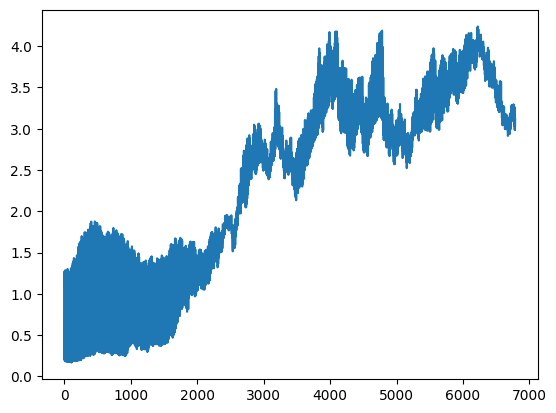

In [10]:
plt.plot(x, y)

In [11]:
y.describe()

count    6786.000000
mean        2.336816
std         1.081411
min         0.167830
25%         1.378390
50%         2.686970
75%         3.184251
max         4.239073
Name: Swap Rate, dtype: float64

In [12]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6786 entries, 0 to 6785
Series name: Swap Rate
Non-Null Count  Dtype  
--------------  -----  
6786 non-null   float64
dtypes: float64(1)
memory usage: 53.1 KB


In [13]:
# Adding plot title.
#plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
#plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
#plt.acorr(y, maxlags = 15) 
 
# Displaying the plot.
#print("The Autocorrelation plot for the data is:")
#plt.grid(True)
 
#plt.show() 

In [14]:
# sm.graphics.tsa.plot_pacf(y, lags=20)
# PACF cutoff at lag 1 -> AR(1) process, use lag 1 as lag variable

In [15]:
# Feature Creation
data = swapori
delay = data['Tenor'].nunique()
data['Swap Rate Lag 1'] = data.groupby(['Tenor'])['Swap Rate'].shift(1)
data['Swap Rate Moving Average 2'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
data['Swap Rate Std 5'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
data.head(100)

,Date,Tenor,Swap Rate,Swap Rate Lag 1,Swap Rate Moving Average 2,Swap Rate Std 5
0,13/1/2021,10.0,1.081333,NaN,NaN,NaN
1,13/1/2021,15.0,1.265960,NaN,NaN,NaN
2,13/1/2021,1.5,0.221625,NaN,NaN,NaN
3,13/1/2021,1.0,0.195474,NaN,NaN,NaN
4,13/1/2021,2.0,0.279370,NaN,NaN,NaN
5,13/1/2021,3.0,0.404284,NaN,NaN,NaN
6,13/1/2021,4.0,0.536341,NaN,NaN,NaN
7,13/1/2021,5.0,0.664396,NaN,NaN,NaN
8,13/1/2021,8.0,0.950975,NaN,NaN,NaN
9,15/1/2021,10.0,1.089143,1.081333,NaN,NaN


In [16]:
# additional feature, previous low and high


In [17]:
features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2','Tenor', 'Swap Rate Std 5']
y = data[target]
X = data[features]

In [18]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, shuffle=False)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 


In [19]:

model = xgb.XGBRegressor(n_estimators = 500, 
                         enable_categorical=True, 
                         learning_rate = 0.15, 
                         early_stopping_rounds = 8
                         )
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

[0]	validation_0-rmse:0.85845	validation_1-rmse:1.22801
[1]	validation_0-rmse:0.73133	validation_1-rmse:1.04776
[2]	validation_0-rmse:0.62330	validation_1-rmse:0.89393
[3]	validation_0-rmse:0.53151	validation_1-rmse:0.76426
[4]	validation_0-rmse:0.45361	validation_1-rmse:0.65371
[5]	validation_0-rmse:0.38753	validation_1-rmse:0.56087
[6]	validation_0-rmse:0.33151	validation_1-rmse:0.48078
[7]	validation_0-rmse:0.28413	validation_1-rmse:0.41398
[8]	validation_0-rmse:0.24410	validation_1-rmse:0.35681
[9]	validation_0-rmse:0.21035	validation_1-rmse:0.30884
[10]	validation_0-rmse:0.18201	validation_1-rmse:0.26745
[11]	validation_0-rmse:0.15830	validation_1-rmse:0.23203
[12]	validation_0-rmse:0.13855	validation_1-rmse:0.20278
[13]	validation_0-rmse:0.12217	validation_1-rmse:0.17865
[14]	validation_0-rmse:0.10874	validation_1-rmse:0.15915
[15]	validation_0-rmse:0.09782	validation_1-rmse:0.14205
[16]	validation_0-rmse:0.08902	validation_1-rmse:0.12867
[17]	validation_0-rmse:0.08195	validation

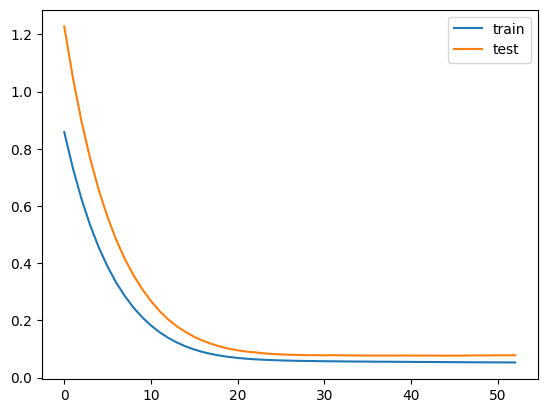

In [20]:
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

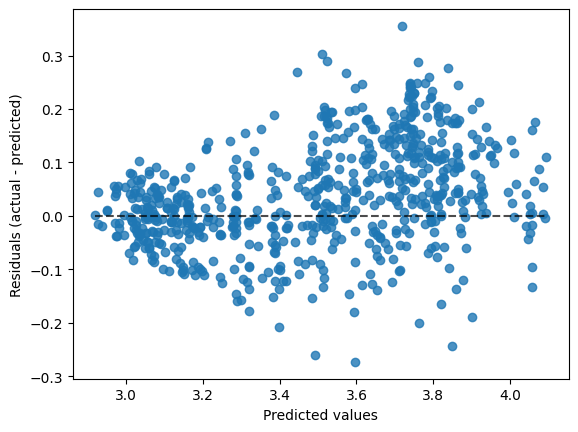

In [21]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

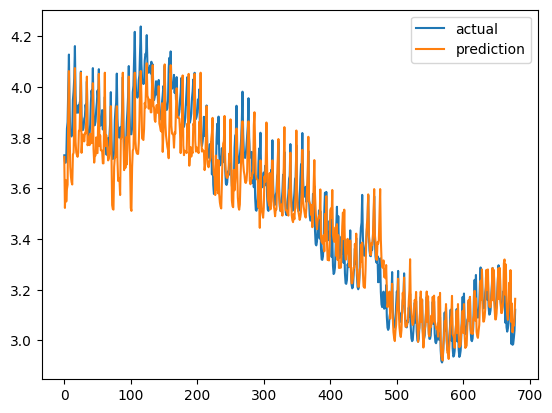

In [22]:
y_test.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

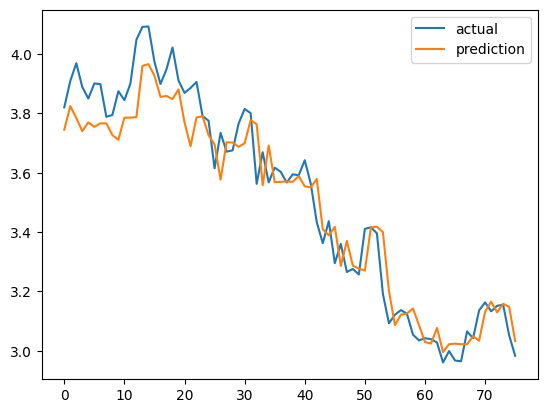

In [23]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=1 - 0.9, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
plt.plot(y_pred2y, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

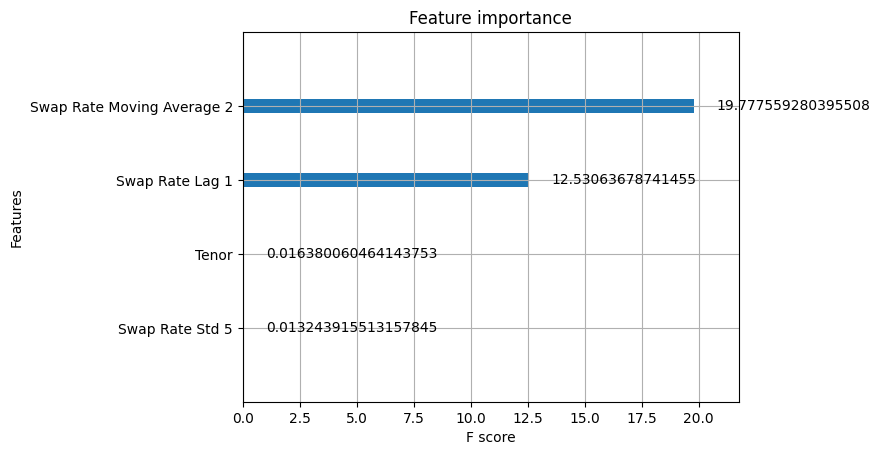

In [24]:
xgb.plot_importance(model, importance_type='gain')

In [25]:
# idea, also include prev swap rate spread max and min and median 